In [5]:
# pip3 install torch torchvision torchaudio numpy scipy polars matplotlib

In [ ]:
from modules import data_loader
from modules import metrics
from modules import model
from modules import learning
from modules import plotting
import matplotlib.pyplot as plt

import matlab.engine
eng = matlab.engine.start_matlab()



Load data from files

In [4]:
data = data_loader.load_data("DPA_200MHz")

config = data["config"]
fs = config["input_signal_fs"]
bw_main_ch = config["bw_main_ch"]
bw_sub_ch = config["bw_sub_ch"]
n_sub_ch = config["n_sub_ch"]
nperseg = float(config["nperseg"])

x_in_tensor = data["train_input"]
x_out_tensor = data["train_output"]
y_in_tensor = data["val_input"]
y_out_tensor = data["val_output"]

In [5]:
# задание целевого сигнала как k*In

gain = metrics.calculate_gain_complex(x_in_tensor, x_out_tensor)
print(f"Gain of PA: {gain:.2f}")

x_target = gain * x_in_tensor
y_target = gain * y_in_tensor


Gain of PA: 2.52


PA model

In [6]:
Ka=La=Kb=Lb=Mb=Kc=Lc=Mc=5

pa_model = model.GeneralizedMemoryPolynomial(Ka, La, Kb, Lb, Mb, Kc, Lc, Mc, model_type="pa_grad")

# проверка, существуют ли сохранённые коэффициенты для этого набора параметров, если нет, то они будут рассчитаны
if not pa_model.load_coefficients():
    pa_model.optimize_coefficients_grad(x_in_tensor, x_out_tensor, epochs=5000, learning_rate=0.01)
    pa_model.save_coefficients()

y_gmp_pa = pa_model.compute_output(y_in_tensor).detach()

nmse_pa = metrics.compute_nmse(y_gmp_pa, y_out_tensor)
print(f"NMSE PA: {nmse_pa}")

Coefficients loaded from model_params/pa_grad_gmp_model_Ka5_La5_Kb6_Lb5_Mb6_Kc6_Lc5_Mc6.pt
NMSE PA: -31.09084129333496


c:\Users\maximp\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\signal\_spectral_py.py:652: UserWarning: Input data is complex, switching to return_onesided=False
  freqs, Pxx = csd(x, x, fs=fs, window=window, nperseg=nperseg,


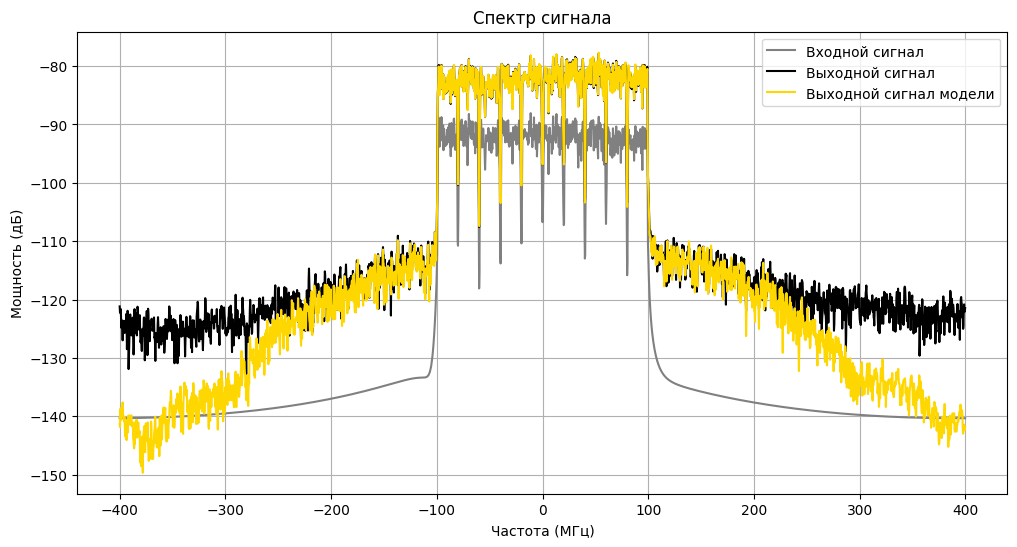

In [8]:
freqs, spectrum_y_in = metrics.power_spectrum(y_in_tensor, fs, nperseg)
_, spectrum_y_out = metrics.power_spectrum(y_out_tensor, fs, nperseg)
_, spectrum_y_gmp_pa = metrics.power_spectrum(y_gmp_pa, fs, nperseg)

spectra = [
    (spectrum_y_in, 'grey', 'Входной сигнал'),
    (spectrum_y_out, 'black', 'Выходной сигнал'),
    (spectrum_y_gmp_pa, 'gold', 'Выходной сигнал модели')
]

plotting.plot_signal_spectra(
    freqs=freqs,
    spectra=spectra,
    title='Спектр сигнала',
    xlabel='Частота (МГц)',
    ylabel='Мощность (дБ)'
)


DLA DPD grad

In [9]:
Ka=La=Kb=Lb=Mb=Kc=Lc=Mc=3

dpd_model_dla_grad = model.GeneralizedMemoryPolynomial(Ka, La, Kb, Lb, Mb, Kc, Lc, Mc, model_type="dpd_dla_grad")

if not dpd_model_dla_grad.load_coefficients():
    learning.optimize_dla_grad(x_in_tensor, x_target, dpd_model_dla_grad, pa_model, epochs=5000, learning_rate=0.001)
    dpd_model_dla_grad.save_coefficients()

y_dpd_dla_grad = dpd_model_dla_grad.compute_output(y_in_tensor).detach()
y_linearized_dla_grad = pa_model.compute_output(y_dpd_dla_grad).detach()

nmse_dla = metrics.compute_nmse(y_linearized_dla_grad, y_target)
print(f"NMSE на выходе усилителя (DLA DPD): {nmse_dla}")

Coefficients loaded from model_params/dpd_dla_grad_gmp_model_Ka3_La3_Kb4_Lb3_Mb4_Kc4_Lc3_Mc4.pt
NMSE на выходе усилителя (DLA DPD): -33.736690521240234


ILA DPD grad

In [10]:
Ka=La=Kb=Lb=Mb=Kc=Lc=Mc=3

dpd_model_ila_grad = model.GeneralizedMemoryPolynomial(Ka, La, Kb, Lb, Mb, Kc, Lc, Mc, model_type="dpd_ila_grad")

if not dpd_model_ila_grad.load_coefficients():
    learning.optimize_ila_grad(dpd_model_ila_grad, x_in_tensor, x_out_tensor, gain, epochs=5000, learning_rate=0.001)
    dpd_model_ila_grad.save_coefficients()

y_dpd_ila_grad = dpd_model_ila_grad.compute_output(y_in_tensor).detach()
y_linearized_ila_grad = pa_model.compute_output(y_dpd_ila_grad).detach()

nmse_ila = metrics.compute_nmse(y_linearized_ila_grad, y_target)
print(f"NMSE на выходе усилителя (ILA DPD): {nmse_ila}")


Coefficients loaded from model_params/dpd_ila_grad_gmp_model_Ka3_La3_Kb4_Lb3_Mb4_Kc4_Lc3_Mc4.pt
NMSE на выходе усилителя (ILA DPD): -33.30488586425781


ILC DPD grad

In [26]:
u_k = learning.ilc_signal_grad(x_in_tensor, x_target, pa_model, max_iterations=500, learning_rate=0.01)

u_k_pa = pa_model.compute_output(u_k).detach()

Iteration 1/500, Loss: 0.06138221547007561
Iteration 2/500, Loss: 0.044837936758995056
Iteration 3/500, Loss: 0.031951528042554855
Iteration 4/500, Loss: 0.022340523079037666
Iteration 5/500, Loss: 0.015473808161914349
Iteration 6/500, Loss: 0.010803205892443657
Iteration 7/500, Loss: 0.0078119151294231415
Iteration 8/500, Loss: 0.0060383016243577
Iteration 9/500, Loss: 0.0050921207293868065
Iteration 10/500, Loss: 0.004662104416638613
Iteration 11/500, Loss: 0.004514709580689669
Iteration 12/500, Loss: 0.004486327525228262
Iteration 13/500, Loss: 0.0044718231074512005
Iteration 14/500, Loss: 0.00441229622811079
Iteration 15/500, Loss: 0.004283087328076363
Iteration 16/500, Loss: 0.004082444589585066
Iteration 17/500, Loss: 0.0038220223505049944
Iteration 18/500, Loss: 0.0035197287797927856
Iteration 19/500, Loss: 0.0031947926618158817
Iteration 20/500, Loss: 0.0028647647704929113
Iteration 21/500, Loss: 0.002543993294239044
Iteration 22/500, Loss: 0.0022430962417274714
Iteration 23/50

In [11]:
Ka=La=Kb=Lb=Mb=Kc=Lc=Mc=3

dpd_model_ilc_grad = model.GeneralizedMemoryPolynomial(Ka, La, Kb, Lb, Mb, Kc, Lc, Mc, model_type="dpd_ilc_grad")

if not dpd_model_ilc_grad.load_coefficients():
    dpd_model_ilc_grad.optimize_coefficients_grad(x_in_tensor, u_k, epochs=5000, learning_rate=0.001)
    dpd_model_ilc_grad.save_coefficients()

y_dpd_ilc_grad = dpd_model_ilc_grad.compute_output(y_in_tensor).detach()
y_linearized_ilc_grad = pa_model.compute_output(y_dpd_ilc_grad).detach()

nmse_ilc = metrics.compute_nmse(y_linearized_ilc_grad, y_target)
print(f"NMSE на выходе усилителя (ILC DPD): {nmse_ilc}")

Coefficients loaded from model_params/dpd_ilc_grad_gmp_model_Ka3_La3_Kb4_Lb3_Mb4_Kc4_Lc3_Mc4.pt
NMSE на выходе усилителя (ILC DPD): -33.425594329833984


Metrics

In [12]:
nmse_after_pa = metrics.compute_nmse(y_gmp_pa, y_target)

print(f"NMSE на выходе усилителя (без DPD): {nmse_after_pa:.2f} db")

print(f"NMSE на выходе усилителя (DLA DPD): {nmse_dla:.2f} db")

print(f"NMSE на выходе усилителя (ILA DPD): {nmse_ila:.2f} db")

print(f"NMSE на выходе усилителя (ILC DPD): {nmse_ilc:.2f} db")

NMSE на выходе усилителя (без DPD): -11.10 db
NMSE на выходе усилителя (DLA DPD): -33.74 db
NMSE на выходе усилителя (ILA DPD): -33.30 db
NMSE на выходе усилителя (ILC DPD): -33.43 db


In [13]:
y_in_acpr = metrics.calculate_acpr(eng, y_in_tensor, fs, bw_main_ch, nperseg)
y_out_acpr = metrics.calculate_acpr(eng, y_out_tensor, fs, bw_main_ch, nperseg)
y_gmp_pa_acpr = metrics.calculate_acpr(eng, y_gmp_pa, fs, bw_main_ch, nperseg)
y_target_acpr = metrics.calculate_acpr(eng, y_target, fs, bw_main_ch, nperseg)

y_linearized_dla_grad_acpr = metrics.calculate_acpr(eng, y_linearized_dla_grad, fs, bw_main_ch, nperseg)
y_linearized_ila_grad_acpr = metrics.calculate_acpr(eng, y_linearized_ila_grad, fs, bw_main_ch, nperseg)
y_linearized_ilc_grad_acpr = metrics.calculate_acpr(eng, y_linearized_ilc_grad, fs, bw_main_ch, nperseg)

print(f"y_in_acpr: {y_in_acpr}")
print(f"y_out_acpr: {y_out_acpr}")
print(f"y_gmp_pa_acpr: {y_gmp_pa_acpr}")
print(f"y_target_acpr: {y_target_acpr}")

print(f"linearized_dla_grad_acpr: {y_linearized_dla_grad_acpr}")
print(f"linearized_ila_grad_acpr: {y_linearized_ila_grad_acpr}")
print(f"linearized_ilc_grad_acpr: {y_linearized_ilc_grad_acpr}")


y_in_acpr: (np.float32(-42.388157), np.float32(-42.388157))
y_out_acpr: (np.float32(-33.900238), np.float32(-33.900238))
y_gmp_pa_acpr: (np.float32(-34.82813), np.float32(-34.82813))
y_target_acpr: (np.float32(-42.388157), np.float32(-42.388157))
linearized_dla_grad_acpr: (np.float32(-41.534763), np.float32(-41.534763))
linearized_ila_grad_acpr: (np.float32(-40.68366), np.float32(-40.68366))
linearized_ilc_grad_acpr: (np.float32(-41.01964), np.float32(-41.01964))


In [ ]:
nmse_uk_pa = metrics.compute_nmse(u_k_pa, x_target)
print(f"NMSE на выходе усилителя (ILC): {nmse_uk_pa:.2f} db")

u_k_acpr = metrics.calculate_acpr(eng, u_k, fs, bw_main_ch, nperseg)
u_k_pa_acpr = metrics.calculate_acpr(eng, u_k_pa, fs, bw_main_ch, nperseg)

_, spectrum_u_k = metrics.power_spectrum(u_k, fs, nperseg)
_, spectrum_u_k_pa = metrics.power_spectrum(u_k_pa, fs, nperseg)
print(f"u_k_acpr: {u_k_acpr}")
print(f"u_k_pa_acpr: {u_k_pa_acpr}")

NMSE на выходе усилителя (ILC): -71.78 db
u_k_acpr: (np.float32(-33.095947), np.float32(-33.095947))
u_k_pa_acpr: (np.float32(-39.504246), np.float32(-39.504246))


Spectrum

In [14]:
freqs, spectrum_y_in = metrics.power_spectrum(y_in_tensor, fs, nperseg)
_, spectrum_y_out = metrics.power_spectrum(y_out_tensor, fs, nperseg)
_, spectrum_y_gmp_pa = metrics.power_spectrum(y_gmp_pa, fs, nperseg)
_, spectrum_y_target = metrics.power_spectrum(y_target, fs, nperseg)

_, spectrum_y_dpd_dla_grad = metrics.power_spectrum(y_dpd_dla_grad, fs, nperseg)
_, spectrum_y_dpd_ila_grad = metrics.power_spectrum(y_dpd_ila_grad, fs, nperseg)
_, spectrum_y_dpd_ilc_grad = metrics.power_spectrum(y_dpd_ilc_grad, fs, nperseg)

_, spectrum_y_linearized_dla_grad = metrics.power_spectrum(y_linearized_dla_grad, fs, nperseg)
_, spectrum_y_linearized_ila_grad = metrics.power_spectrum(y_linearized_ila_grad, fs, nperseg)
_, spectrum_y_linearized_ilc_grad = metrics.power_spectrum(y_linearized_ilc_grad, fs, nperseg)

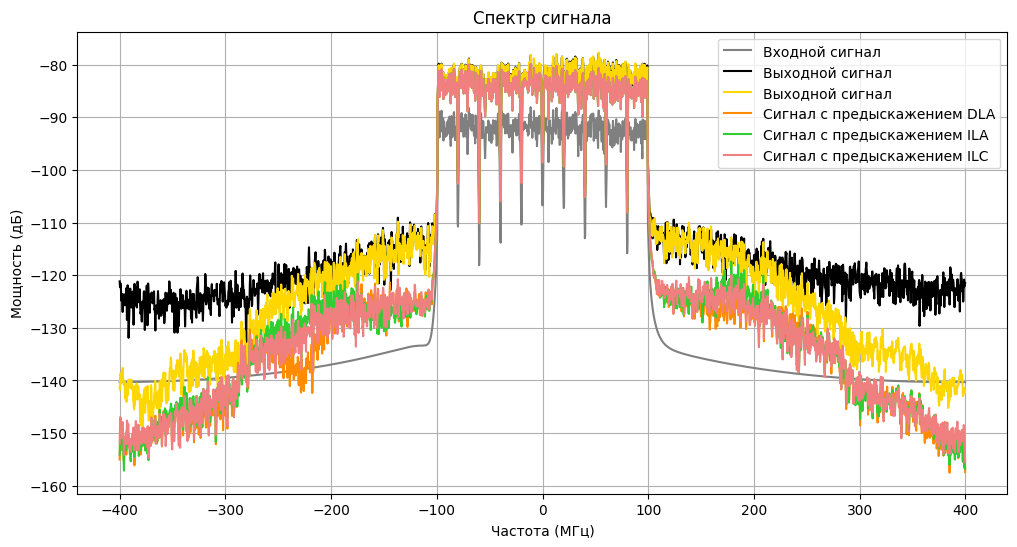

In [15]:
# построение спектра

spectra = [
    (spectrum_y_in, 'grey', 'Входной сигнал'),
    (spectrum_y_out, 'black', 'Выходной сигнал'),
    (spectrum_y_gmp_pa, 'gold', 'Выходной сигнал'),
    # (spectrum_y_target, 'red', 'Идеальный линейный сигнал (k*In)'),
    (spectrum_y_linearized_dla_grad, 'darkorange', 'Сигнал с предыскажением DLA'),
    (spectrum_y_linearized_ila_grad, 'limegreen', 'Сигнал с предыскажением ILA'),
    (spectrum_y_linearized_ilc_grad, 'lightcoral', 'Сигнал с предыскажением ILC')
]

plotting.plot_signal_spectra(
    freqs=freqs,
    spectra=spectra,
    title='Спектр сигнала',
    xlabel='Частота (МГц)',
    ylabel='Мощность (дБ)'
)


In [16]:
spectra = [
    (spectrum_y_in, 'grey', 'Входной сигнал'),
    (spectrum_y_out, 'k', 'Выходной сигнал'),
    (spectrum_y_gmp_pa, 'gold', 'Выходной сигнал модели'),
    (spectrum_y_target, 'red', 'Идеальный линейный сигнал (k*In)'),
    (spectrum_u_k_pa, 'green', 'Оптимальный сигнал ILC')
]

plotting.plot_signal_spectra(
    freqs=freqs,
    spectra=spectra,
    title='Спектр сигнала',
    xlabel='Частота (МГц)',
    ylabel='Мощность (дБ)'
)

NameError: name 'spectrum_u_k_pa' is not defined

AM/AM & AM/PM

In [17]:
y_in_am_am, y_out_am_am = metrics.calculate_am_am(y_in_tensor, y_out_tensor)
y_in_am_pm, y_in_phase_am_pm = metrics.calculate_am_pm(y_in_tensor, y_out_tensor)

_, y_pa_am_am = metrics.calculate_am_am(y_in_tensor, y_gmp_pa)
_, y_pa_phase_am_pm = metrics.calculate_am_pm(y_in_tensor, y_gmp_pa)

_, y_target_am_am = metrics.calculate_am_am(y_in_tensor, y_target)
_, y_target_phase_am_pm = metrics.calculate_am_pm(y_in_tensor, y_target)

# x_in_am_am, u_k_am_am = metrics.calculate_am_am(x_in_tensor, u_k)
# x_in_am_pm, u_k_phase_am_pm = metrics.calculate_am_pm(x_in_tensor, u_k)

# _, u_k_pa_am_am = metrics.calculate_am_am(x_in_tensor, u_k_pa)
# _, u_k_pa_phase_am_pm = metrics.calculate_am_pm(x_in_tensor, u_k_pa)

# dpd
_, y_dpd_dla_grad_am_am = metrics.calculate_am_am(y_in_tensor, y_dpd_dla_grad)
_, y_dpd_dla_grad_phase_am_pm = metrics.calculate_am_pm(y_in_tensor, y_dpd_dla_grad)

_, y_dpd_ila_grad_am_am = metrics.calculate_am_am(y_in_tensor, y_dpd_ila_grad)
_, y_dpd_ila_grad_phase_am_pm = metrics.calculate_am_pm(y_in_tensor, y_dpd_ila_grad)

_, y_dpd_ilc_grad_am_am = metrics.calculate_am_am(y_in_tensor, y_dpd_ilc_grad)
_, y_dpd_ilc_grad_phase_am_pm = metrics.calculate_am_pm(y_in_tensor, y_dpd_ilc_grad)

#linearized
_, y_linearized_dla_grad_am_am = metrics.calculate_am_am(y_in_tensor, y_linearized_dla_grad)
_, y_linearized_dla_grad_phase_am_pm = metrics.calculate_am_pm(y_in_tensor, y_linearized_dla_grad)

_, y_linearized_ila_grad_am_am = metrics.calculate_am_am(y_in_tensor, y_linearized_ila_grad)
_, y_linearized_ila_grad_phase_am_pm = metrics.calculate_am_pm(y_in_tensor, y_linearized_ila_grad)

_, y_linearized_ilc_grad_am_am = metrics.calculate_am_am(y_in_tensor, y_linearized_ilc_grad)
_, y_linearized_ilc_grad_phase_am_pm = metrics.calculate_am_pm(y_in_tensor, y_linearized_ilc_grad)


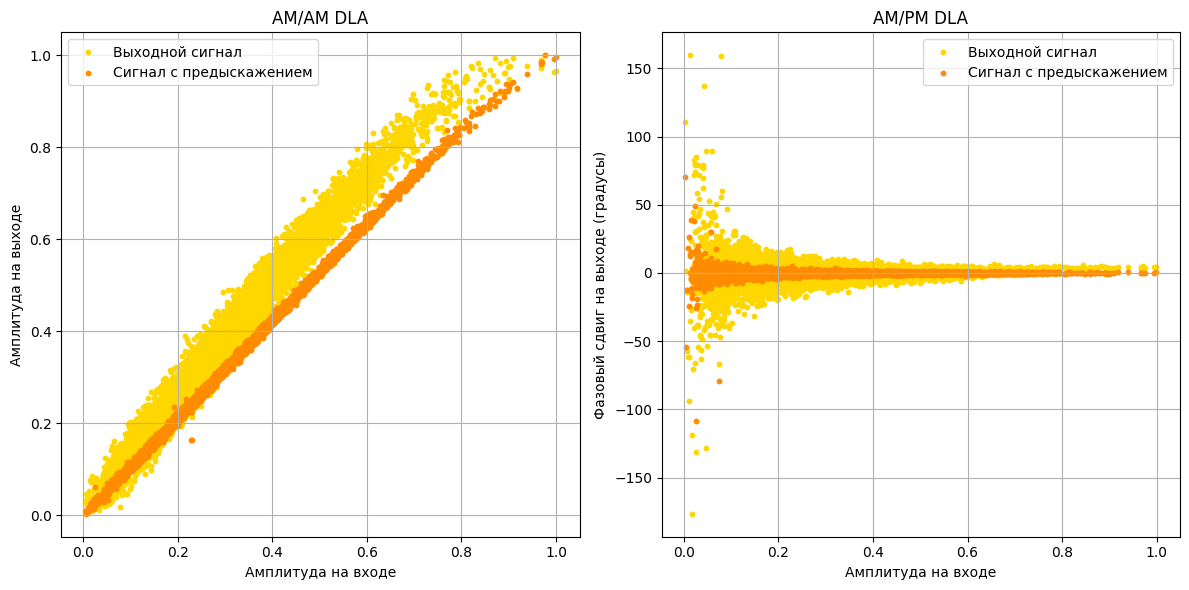

In [18]:
#DLA

am_am_data = [
    (y_in_am_am, y_pa_am_am, 'gold', 'Выходной сигнал'),
    # (y_in_am_am, y_dpd_dla_grad_am_am, 'magenta', 'Сигнал на выходе DPD'),
    (y_in_am_am, y_linearized_dla_grad_am_am, 'darkorange', 'Сигнал с предыскажением'),
]

am_pm_data = [
    (y_in_am_pm, y_pa_phase_am_pm, 'gold', 'Выходной сигнал'),
    (y_in_am_pm, y_linearized_dla_grad_phase_am_pm, 'darkorange', 'Сигнал с предыскажением'),
]

plotting.plot_am_am_pm(
    am_am_data=am_am_data,
    am_pm_data=am_pm_data,
    figsize=(12, 6),
    titles=("AM/AM DLA", "AM/PM DLA"),
    xlabels=("Амплитуда на входе", "Амплитуда на входе"),
    ylabels=("Амплитуда на выходе", "Фазовый сдвиг на выходе (градусы)")
)



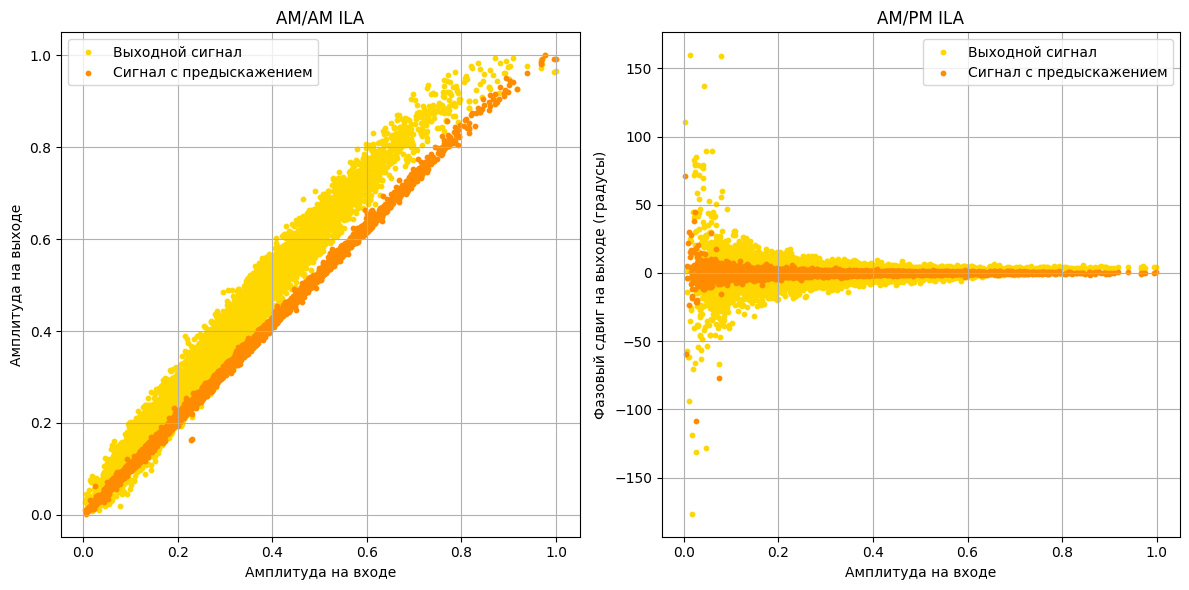

In [19]:
#ILA

am_am_data = [
    (y_in_am_am, y_pa_am_am, 'gold', 'Выходной сигнал'),
    # (y_in_am_am, y_dpd_ila_grad_am_am, 'magenta', 'Сигнал на выходе DPD'),
    (y_in_am_am, y_linearized_ila_grad_am_am, 'darkorange', 'Сигнал с предыскажением'),
]

am_pm_data = [
    (y_in_am_pm, y_pa_phase_am_pm, 'gold', 'Выходной сигнал'),
    (y_in_am_pm, y_linearized_ila_grad_phase_am_pm, 'darkorange', 'Сигнал с предыскажением'),
]

plotting.plot_am_am_pm(
    am_am_data=am_am_data,
    am_pm_data=am_pm_data,
    figsize=(12, 6),
    titles=("AM/AM ILA", "AM/PM ILA"),
    xlabels=("Амплитуда на входе", "Амплитуда на входе"),
    ylabels=("Амплитуда на выходе", "Фазовый сдвиг на выходе (градусы)")
)


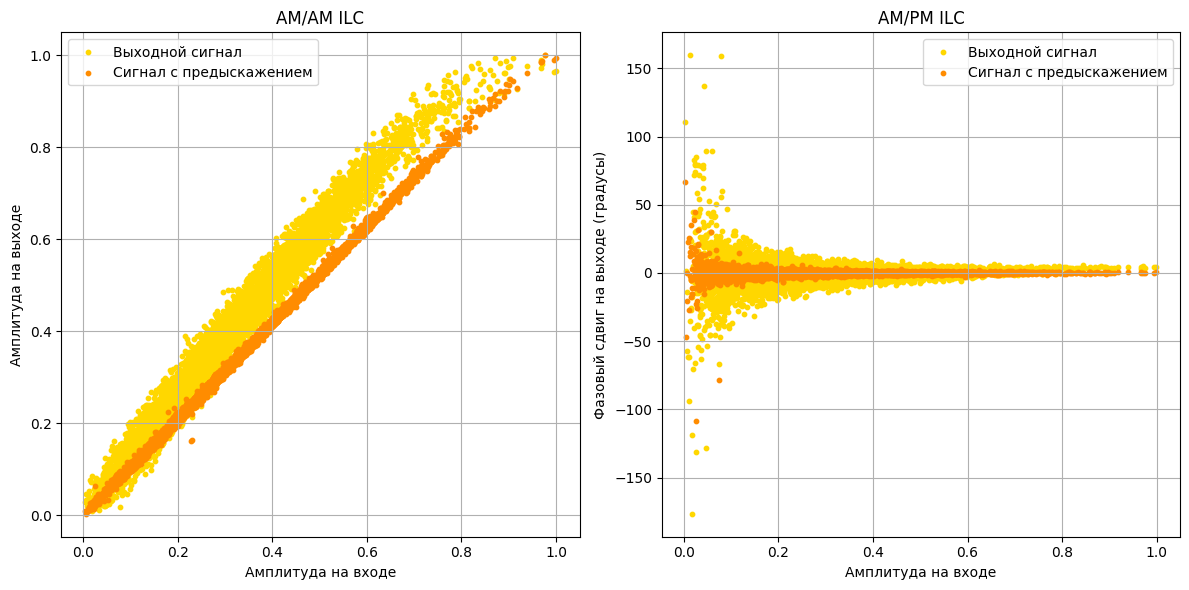

In [20]:
#ILC

am_am_data = [
    (y_in_am_am, y_pa_am_am, 'gold', 'Выходной сигнал'),
    # (y_in_am_am, y_dpd_ilc_grad_am_am, 'magenta', 'Сигнал на выходе корректора'),
    (y_in_am_am, y_linearized_ilc_grad_am_am, 'darkorange', 'Сигнал с предыскажением'),
]

am_pm_data = [
    (y_in_am_pm, y_pa_phase_am_pm, 'gold', 'Выходной сигнал'),
    (y_in_am_pm, y_linearized_ilc_grad_phase_am_pm, 'darkorange', 'Сигнал с предыскажением'),
]

plotting.plot_am_am_pm(
    am_am_data=am_am_data,
    am_pm_data=am_pm_data,
    figsize=(12, 6),
    titles=("AM/AM ILC", "AM/PM ILC"),
    xlabels=("Амплитуда на входе", "Амплитуда на входе"),
    ylabels=("Амплитуда на выходе", "Фазовый сдвиг на выходе (градусы)")
)


Add noise

In [28]:
y_pa_2 = pa_model.compute_output(y_in_tensor).detach()
snr = 20

y_gmp_pa_2 = metrics.add_complex_noise(y_pa_2, snr, fs, bw_main_ch)

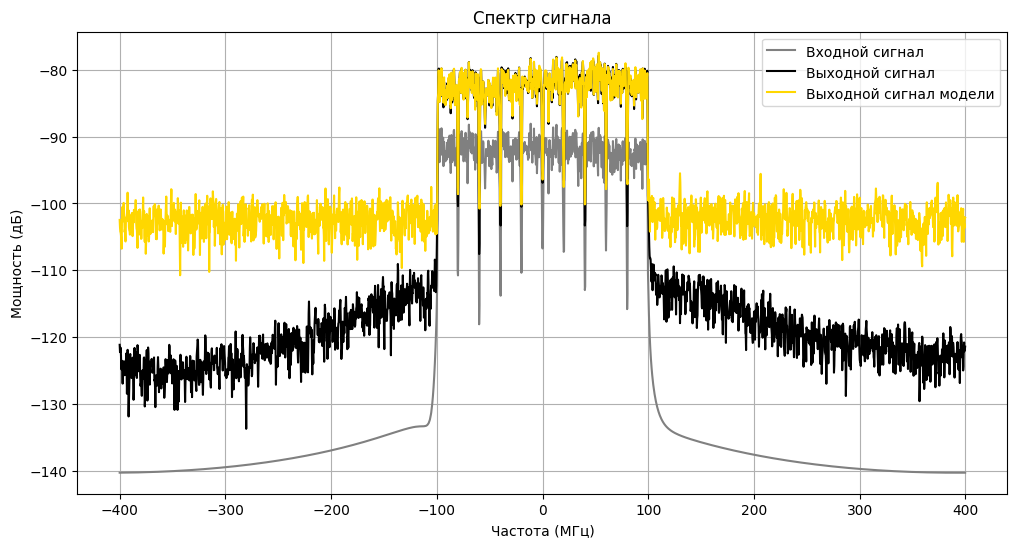

In [29]:
freqs, spectrum_y_in = metrics.power_spectrum(y_in_tensor, fs, nperseg)
_, spectrum_y_out = metrics.power_spectrum(y_out_tensor, fs, nperseg)
_, spectrum_y_gmp_pa_2 = metrics.power_spectrum(y_gmp_pa_2, fs, nperseg)

spectra = [
    (spectrum_y_in, 'grey', 'Входной сигнал'),
    (spectrum_y_out, 'black', 'Выходной сигнал'),
    (spectrum_y_gmp_pa_2, 'gold', 'Выходной сигнал модели')
]

plotting.plot_signal_spectra(
    freqs=freqs,
    spectra=spectra,
    title='Спектр сигнала',
    xlabel='Частота (МГц)',
    ylabel='Мощность (дБ)'
)


In [ ]:
snr_range = list(range(20, 41, 5))

nmse_dla_list = []
acpr_left_dla_list = []
acpr_right_dla_list = []

nmse_ila_list = []
acpr_left_ila_list = []
acpr_right_ila_list = []

nmse_ilc_list = []
acpr_left_ilc_list = []
acpr_right_ilc_list = []

nmse_uk_list = []
acpr_left_uk_list = []
acpr_right_uk_list = []

Ka = La = Kb = Lb = Mb = Kc = Lc = Mc = 2
epochs = 500
lr = 0.01
num_realizations = 100

for snr in snr_range:
    print(f"Current SNR: {snr} ----------------------------------")

    # DLA
    dpd_dla = model.GeneralizedMemoryPolynomial(Ka, La, Kb, Lb, Mb, Kc, Lc, Mc, model_type="dpd_dla")
    learning.optimize_dla_grad(x_in_tensor, x_target, dpd_dla, pa_model, epochs, lr, True, snr, fs, bw_main_ch)
    y_dla_pa = pa_model.compute_output(dpd_dla.compute_output(y_in_tensor)).detach()

    nmse_dla, acpr_left_dla, acpr_right_dla = metrics.noise_realizations(num_realizations, eng, y_dla_pa, y_target, snr, fs, bw_main_ch, nperseg)
    nmse_dla_list.append(nmse_dla)
    acpr_left_dla_list.append(acpr_left_dla)
    acpr_right_dla_list.append(acpr_right_dla)

    # ILA
    dpd_ila = model.GeneralizedMemoryPolynomial(Ka, La, Kb, Lb, Mb, Kc, Lc, Mc, model_type="dpd_ila")
    learning.optimize_ila_grad(dpd_ila, x_in_tensor, x_target, gain, epochs, lr, pa_model, True, snr, fs, bw_main_ch)
    y_ila_pa = pa_model.compute_output(dpd_ila.compute_output(y_in_tensor)).detach()
    
    nmse_ila, acpr_left_ila, acpr_right_ila = metrics.noise_realizations(num_realizations, eng, y_ila_pa, y_target, snr, fs, bw_main_ch, nperseg)
    nmse_ila_list.append(nmse_ila)
    acpr_left_ila_list.append(acpr_left_ila)
    acpr_right_ila_list.append(acpr_right_ila)

    # ILC + UK
    dpd_ilc = model.GeneralizedMemoryPolynomial(Ka, La, Kb, Lb, Mb, Kc, Lc, Mc, model_type="dpd_ilc")
    uk = learning.ilc_signal_grad(x_in_tensor, x_target, pa_model, 500, 0.01, True, snr, fs, bw_main_ch)
    
    uk_pa = pa_model.compute_output(uk).detach()
    nmse_uk, acpr_left_uk, acpr_right_uk = metrics.noise_realizations(num_realizations, eng, uk_pa, x_target, snr, fs, bw_main_ch, nperseg)
    nmse_uk_list.append(nmse_uk)
    acpr_left_uk_list.append(acpr_left_uk)
    acpr_right_uk_list.append(acpr_right_uk)

    dpd_ilc.optimize_coefficients_grad(x_in_tensor, uk, epochs, lr)
    y_ilc_pa = pa_model.compute_output(dpd_ilc.compute_output(y_in_tensor)).detach()
    
    nmse_ilc, acpr_left_ilc, acpr_right_ilc = metrics.noise_realizations(num_realizations, eng, y_ilc_pa, y_target, snr, fs, bw_main_ch, nperseg)
    nmse_ilc_list.append(nmse_ilc)
    acpr_left_ilc_list.append(acpr_left_ilc)
    acpr_right_ilc_list.append(acpr_right_ilc)

Current SNR: 20 ----------------------------------
Epoch [1/300], Loss: 0.7621204853057861
Epoch [2/300], Loss: 0.39615848660469055
Epoch [3/300], Loss: 0.1464933156967163
Epoch [4/300], Loss: 0.1379103809595108
Epoch [5/300], Loss: 0.24270635843276978
Epoch [6/300], Loss: 0.19762159883975983
Epoch [7/300], Loss: 0.17235715687274933
Epoch [8/300], Loss: 0.16800187528133392
Epoch [9/300], Loss: 0.14547045528888702
Epoch [10/300], Loss: 0.1085553988814354
Epoch [11/300], Loss: 0.07834642380475998
Epoch [12/300], Loss: 0.06901569664478302
Epoch [13/300], Loss: 0.07760807126760483
Epoch [14/300], Loss: 0.08645668625831604
Epoch [15/300], Loss: 0.08853866904973984
Epoch [16/300], Loss: 0.08290709555149078
Epoch [17/300], Loss: 0.07489173859357834
Epoch [18/300], Loss: 0.0668722614645958
Epoch [19/300], Loss: 0.05950402095913887
Epoch [20/300], Loss: 0.055367205291986465
Epoch [21/300], Loss: 0.0540204793214798
Epoch [22/300], Loss: 0.0529157854616642
Epoch [23/300], Loss: 0.0506674200296402

In [ ]:

# snr_range = [snr for snr in range(20, 41, 2)]
# nmse_dla_list = []
# acpr_left_dla_list = []
# acpr_right_dla_list = []

# nmse_ila_list = []
# acpr_left_ila_list = []
# acpr_right_ila_list = []

# nmse_ilc_list = []
# acpr_left_ilc_list = []
# acpr_right_ilc_list = []

# nmse_uk_list = []
# acpr_left_uk_list = []
# acpr_right_uk_list = []

# Ka=La=Kb=Lb=Mb=Kc=Lc=Mc=3

# epochs=300
# lr = 0.01
# num_realizations = 1

# for snr in snr_range:
#     print(f"Current SNR: {snr} -----------------------------------------------------------------------------------------------------")

#     # DLA
#     nmse_dla_values = []
#     acpr_left_dla_values = []
#     acpr_right_dla_values = []

#     dpd_dla = model.GeneralizedMemoryPolynomial(Ka, La, Kb, Lb, Mb, Kc, Lc, Mc, model_type="dpd_dla")

#     learning.optimize_dla_grad(x_in_tensor, x_target, dpd_dla, pa_model, epochs=epochs, learning_rate=lr, 
#                             add_noise=True, snr=snr, fs=fs, bw=bw_main_ch)
#     y_dla = dpd_dla.compute_output(y_in_tensor).detach()
#     y_dla_pa = pa_model.compute_output(y_dla).detach()

#     for _ in range(num_realizations):
#         y_dla_pa_noise = spectrum_analysis.add_complex_noise(y_dla_pa, snr, fs, bw_main_ch)

#         nmse_dla = metrics.compute_nmse(y_dla_pa_noise, y_target)
#         nmse_dla_values.append(nmse_dla)

#         acpr_left_dla, acpr_right_dla = spectrum_analysis.calculate_acpr(eng, y_dla_pa_noise, fs, bw_main_ch, nperseg)
#         acpr_left_dla_values.append(acpr_left_dla)
#         acpr_right_dla_values.append(acpr_right_dla)

#     nmse_dla_list.append(sum(nmse_dla_values)/num_realizations)
#     acpr_left_dla_list.append(sum(acpr_left_dla_values)/num_realizations)
#     acpr_right_dla_list.append(sum(acpr_right_dla_values)/num_realizations)


#     # ILA
#     nmse_ila_values = []
#     dpd_ila = model.GeneralizedMemoryPolynomial(Ka, La, Kb, Lb, Mb, Kc, Lc, Mc, model_type="dpd_ila")
#     learning.optimize_ila_grad(dpd_ila, x_in_tensor, x_target, gain, epochs=epochs, learning_rate=lr, 
#                                     pa_model=pa_model, add_noise=True, snr=snr, fs=fs, bw=bw_main_ch)
#     y_ila = dpd_ila.compute_output(y_in_tensor).detach()
#     y_ila_pa = pa_model.compute_output(y_ila).detach()
#     for _ in range(num_realizations):
#         y_ila_pa_noise = spectrum_analysis.add_complex_noise(y_ila_pa, snr, fs, bw_main_ch)
#         nmse_ila = metrics.compute_nmse(y_ila_pa_noise, y_target)
#         nmse_ila_values.append(nmse_ila)
#     nmse_ila_list.append(sum(nmse_ila_values)/num_realizations)


#     # ILC
#     nmse_uk_values = []
#     nmse_ilc_values = []
#     dpd_ilc = model.GeneralizedMemoryPolynomial(Ka, La, Kb, Lb, Mb, Kc, Lc, Mc, model_type="dpd_ilc")
#     uk = learning.ilc_signal_grad(x_in_tensor, x_target, pa_model, max_iterations=300, learning_rate=0.01, 
#                                 add_noise=True, snr=snr, fs=fs, bw=bw_main_ch)

#     uk_pa = pa_model.compute_output(uk).detach()
#     for _ in range(num_realizations):
#         uk_pa_noise = spectrum_analysis.add_complex_noise(uk_pa, snr, fs, bw_main_ch)
#         nmse_uk = metrics.compute_nmse(uk_pa_noise, x_target)
#         nmse_uk_values.append(nmse_uk)
#     nmse_uk_list.append(sum(nmse_uk_values)/num_realizations)

#     dpd_ilc.optimize_coefficients_grad(x_in_tensor, uk, epochs=epochs, learning_rate=lr)
#     y_ilc = dpd_ilc.compute_output(y_in_tensor).detach()
#     y_ilc_pa = pa_model.compute_output(y_ilc).detach()
#     for _ in range(num_realizations):
#         y_ilc_pa_noise = spectrum_analysis.add_complex_noise(y_ilc_pa, snr, fs, bw_main_ch)
#         nmse_ilc = metrics.compute_nmse(y_ilc_pa_noise, y_target)
#         nmse_ilc_values.append(nmse_ilc)
#     nmse_ilc_list.append(sum(nmse_ilc_values)/num_realizations)



In [37]:
print(f"snr_range: {snr_range}")
print()
print(f"nmse_dla_list: {nmse_dla_list}")
print(f"acpr_left_dla_list: {acpr_left_dla_list}")
print(f"acpr_right_dla_list: {acpr_right_dla_list}")
print()

print(f"nmse_ila_list : {nmse_ila_list}")
print(f"acpr_left_ila_list: {acpr_left_ila_list}")
print(f"acpr_right_ila_list: {acpr_right_ila_list}")
print()

print(f"nmse_ilc_list: {nmse_ilc_list}")
print(f"acpr_left_ilc_list: {acpr_left_ilc_list}")
print(f"acpr_right_ilc_list: {acpr_right_ilc_list}")
print()

print(f"nmse_uk_list: {nmse_uk_list}")
print(f"acpr_left_uk_list: {acpr_left_uk_list}")
print(f"acpr_right_uk_list: {acpr_right_uk_list}")

snr_range: [20, 25, 30, 35, 40]

nmse_dla_list: [tensor(-14.0946), tensor(-18.8576), tensor(-23.4681), tensor(-27.4443), tensor(-30.2868)]
acpr_left_dla_list: [np.float32(-19.943134), np.float32(-24.82618), np.float32(-29.598696), np.float32(-33.894577), np.float32(-37.257614)]
acpr_right_dla_list: [np.float32(-19.943134), np.float32(-24.82618), np.float32(-29.598696), np.float32(-33.894577), np.float32(-37.257614)]

nmse_ila_list : [tensor(-13.9575), tensor(-18.7843), tensor(-23.4196), tensor(-27.4633), tensor(-30.3493)]
acpr_left_ila_list: [np.float32(-19.954647), np.float32(-24.84618), np.float32(-29.590265), np.float32(-33.885605), np.float32(-37.160152)]
acpr_right_ila_list: [np.float32(-19.954647), np.float32(-24.84618), np.float32(-29.590265), np.float32(-33.885605), np.float32(-37.160152)]

nmse_ilc_list: [tensor(-14.0915), tensor(-18.8734), tensor(-23.4760), tensor(-27.5147), tensor(-30.4188)]
acpr_left_ilc_list: [np.float32(-19.936888), np.float32(-24.83925), np.float32(-29.6

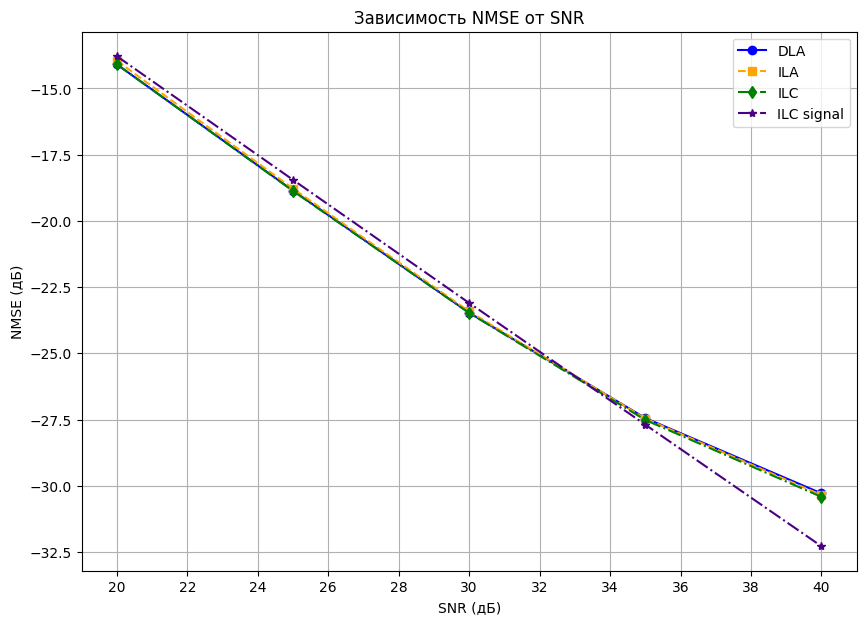

In [ ]:

plt.figure(figsize=(10, 7))
plt.plot(snr_range, nmse_dla_list, marker='o', color='blue', linestyle='-', label="DLA")
plt.plot(snr_range, nmse_ila_list, marker='s', color='orange', linestyle='--', label="ILA")
plt.plot(snr_range, nmse_ilc_list, marker='d', color='green', linestyle='-.', label="ILC")
plt.plot(snr_range, nmse_uk_list, marker='*', color='indigo', linestyle='-.', label="ILC signal")

plt.xlabel("SNR (дБ)")
plt.ylabel("NMSE (дБ)")
plt.title("Зависимость NMSE от SNR")
plt.xticks(range(20, 41, 2))
plt.legend()
plt.grid(True)

plt.show()


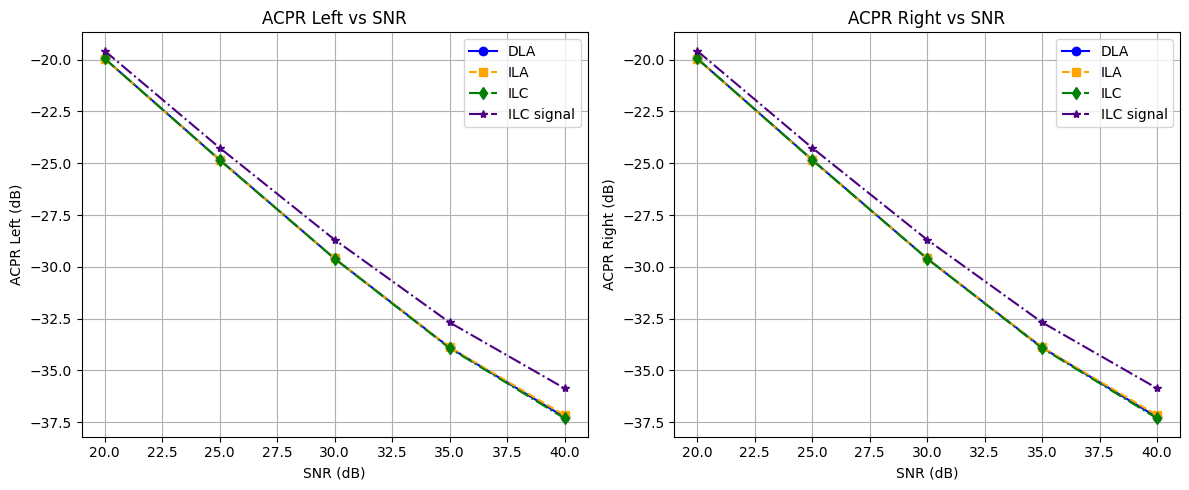

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(snr_range, acpr_left_dla_list, marker='o', color='blue', linestyle='-', label="DLA")
plt.plot(snr_range, acpr_left_ila_list, marker='s', color='orange', linestyle='--', label="ILA")
plt.plot(snr_range, acpr_left_ilc_list, marker='d', color='green', linestyle='-.', label="ILC")
plt.plot(snr_range, acpr_left_uk_list, marker='*', color='indigo', linestyle='-.', label="ILC signal")
plt.title('ACPR Left vs SNR')
plt.xlabel('SNR (dB)')
plt.ylabel('ACPR Left (dB)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(snr_range, acpr_right_dla_list, marker='o', color='blue', linestyle='-', label="DLA")
plt.plot(snr_range, acpr_right_ila_list, marker='s', color='orange', linestyle='--', label="ILA")
plt.plot(snr_range, acpr_right_ilc_list, marker='d', color='green', linestyle='-.', label="ILC")
plt.plot(snr_range, acpr_right_uk_list, marker='*', color='indigo', linestyle='-.', label="ILC signal")
plt.title('ACPR Right vs SNR')
plt.xlabel('SNR (dB)')
plt.ylabel('ACPR Right (dB)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
eng.quit()